## Deep Learning Image Classification Comparison



In [1]:
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install seaborn
%pip install scikit-learn
%pip install statsmodels
%pip install plotly
%pip install plotly_express
%pip install torchvision
%pip install torch

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\python.exe -m pip install --upgrade pip' command.



Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\python.exe -m pip install --upgrade pip' command.



Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\python.exe -m pip install --upgrade pip' command.



Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



You should consider upgrading via the 'c:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\python.exe -m pip install --upgrade pip' command.



Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



You should consider upgrading via the 'c:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\python.exe -m pip install --upgrade pip' command.


In [2]:
import torch as torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
from torchvision import models
import random
from torch.utils.data import random_split

Loading Data and augmentations

In [3]:
class RandomApplyColorJitter:
    def __init__(self, p=0.5, brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5):
        self.p = p
        self.color_jitter = transforms.ColorJitter(brightness=brightness, contrast=contrast, saturation=saturation, hue=hue)

    def __call__(self, img):
        if random.random() < self.p:
            return self.color_jitter(img)
        return img

def load_data():
    transform_train = transforms.Compose([
        transforms.RandomCrop(64),
        transforms.RandomHorizontalFlip(),
        RandomApplyColorJitter(p=0.3),  # Apply ColorJitter with 30% probability
        transforms.ToTensor(),
    ])

    transform_test = transforms.Compose([
        transforms.CenterCrop(64),
        transforms.ToTensor(),
    ])

    train_dataset = torchvision.datasets.STL10(root="./data", split='train', download=True, transform=transform_train)
    test_dataset = torchvision.datasets.STL10(root="./data", split='test', download=True, transform=transform_test)

    # Assuming 'train_dataset' is your original training dataset
    validation_split = 0.15  # 15% of the training data for validation
    dataset_size = len(train_dataset)
    validation_size = int(validation_split * dataset_size)
    train_size = dataset_size - validation_size

    train_dataset, validation_dataset = random_split(train_dataset, [train_size, validation_size], generator=torch.Generator().manual_seed(42))

    # Create data loaders for the training and validation sets
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    return train_loader, test_loader, validation_dataset

train_loader, test_loader, validation_loader = load_data()


Files already downloaded and verified
Files already downloaded and verified


showing augmentation:

Example training image before and after augmentation:


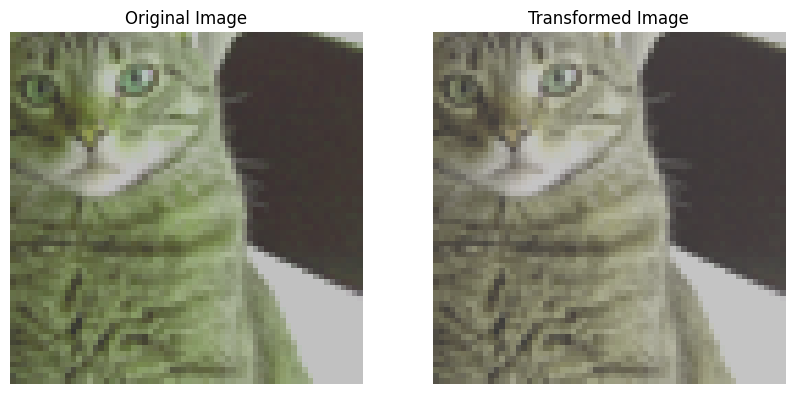

In [4]:
# Display an example image before and after transformation
def show_image_before_after(loader):
    data_iter = iter(loader)
    images, _ = next(data_iter)
    img = images[0]

    # Display original image
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img.permute(1, 2, 0))
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Apply transformation and display transformed image
    transform = RandomApplyColorJitter(p=1.0)  # Ensure ColorJitter is applied
    transformed_img = transform(img)
    axes[1].imshow(transformed_img.permute(1, 2, 0))
    axes[1].set_title("Transformed Image")
    axes[1].axis('off')

    plt.show()

print("Example training image before and after augmentation:")
show_image_before_after(train_loader)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classes = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']

Visualizetions (printing 4 exsamples from each class):

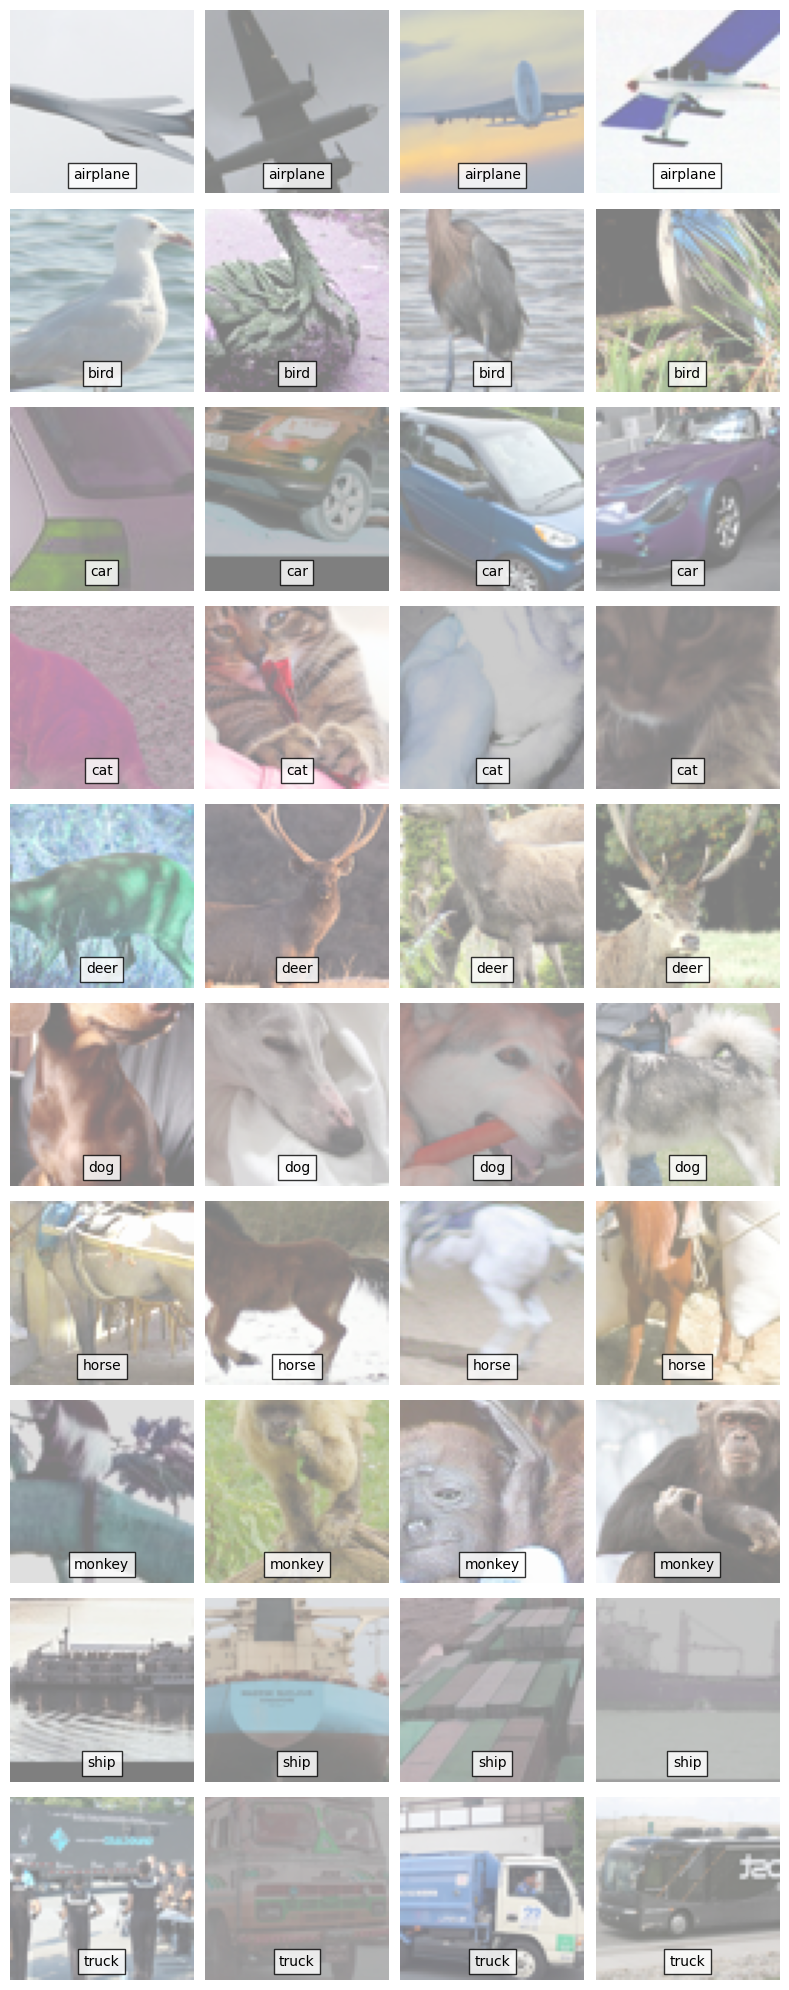

In [6]:
# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Get 4 images from each class
num_classes = len(classes)  # Assuming 'classes' is defined as a list of class names
num_examples = 4
fig, axes = plt.subplots(num_classes, num_examples, figsize=(num_examples * 2, num_classes * 2))

for i, class_name in enumerate(classes):
    axes[i, 0].set_ylabel(class_name, rotation=0, size='large', labelpad=40)
    class_images = []
    for images, labels in train_loader:
        for img, label in zip(images, labels):
            if classes[label] == class_name:
                class_images.append(img)
            if len(class_images) == num_examples:
                break
        if len(class_images) == num_examples:
            break
    for j in range(num_examples):
        axes[i, j].imshow(np.transpose(class_images[j].numpy() / 2 + 0.5, (1, 2, 0)))
        axes[i, j].axis('off')
        axes[i, j].text(0.5, 0.1, class_name, color='black',
                       fontsize=10, ha='center', va='center',
                       transform=axes[i, j].transAxes,
                       bbox=dict(facecolor='white', alpha=0.8))  # Add label to each image
    axes[i, 0].set_ylabel(class_name, rotation=0, size='large', labelpad=40)  # Row label

plt.tight_layout()
plt.show()

Train and Evaluate , and Plot functions:

In [7]:
def train_and_evaluate(model, train_loader, validation_loader, criterion, optimizer, num_epochs):
    train_acc = []
    val_acc = []
    train_loss = []
    val_loss = []

    print(f"Starting training model: {model.__class__.__name__} with {optimizer.__class__.__name__} and {criterion.__class__.__name__}, {num_epochs} epochs")

    for epoch in range(num_epochs):
        model.train()
        correct = 0
        total = 0
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            images = images.view(-1, input_size)

            if len(labels.shape) == 0:  # Check if labels are 0-dimensional
              labels = labels.unsqueeze(0)  # Add a dimension


            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss.append(running_loss / len(train_loader))
        train_acc.append(100 * correct / total)

        model.eval()
        correct = 0
        total = 0
        running_loss = 0.0
        with torch.no_grad():
            for images, labels in validation_loader:
                images = images.to(device)
                labels = torch.tensor(labels).to(device)
                images = images.view(-1, input_size)

                if len(labels.shape) == 0:  # Check if labels are 0-dimensional
                  labels = labels.unsqueeze(0)  # Add a dimension

                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss.append(running_loss / len(validation_loader))
        val_acc.append(100 * correct / total)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss[-1]:.4f}, Train Accuracy: {train_acc[-1]:.2f}%, Validation Loss: {val_loss[-1]:.4f}, Validation Accuracy: {val_acc[-1]:.2f}%')

    return train_acc, val_acc, train_loss, val_loss

def plot_curves(train_acc, val_acc, train_loss, val_loss):
    epochs = range(1, len(train_acc) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()




1. Logistic regression over flattened version of the images

In [8]:
def test_hyperparameter_tuned_log_reg_model(Log_Reg_model, test_loader, input_size, device):
    Log_Reg_model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            images = images.view(-1, input_size)

            outputs = Log_Reg_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')

Re-establish

In [9]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
from torchvision import models
import random
from torch.utils.data import random_split

# Define the logistic regression model
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.linear(x)



Test different configurations of hyperparameters

Starting training model: LogisticRegression with SGD and CrossEntropyLoss, 5 epochs
Epoch [1/5], Train Loss: 9.1112, Train Accuracy: 14.19%, Validation Loss: 7.5002, Validation Accuracy: 12.67%
Epoch [2/5], Train Loss: 12.6669, Train Accuracy: 12.78%, Validation Loss: 9.1977, Validation Accuracy: 10.27%
Epoch [3/5], Train Loss: 14.1563, Train Accuracy: 14.19%, Validation Loss: 13.3592, Validation Accuracy: 13.73%
Epoch [4/5], Train Loss: 10.8211, Train Accuracy: 14.16%, Validation Loss: 13.1952, Validation Accuracy: 12.67%
Epoch [5/5], Train Loss: 13.2836, Train Accuracy: 13.46%, Validation Loss: 14.8456, Validation Accuracy: 13.47%
Accuracy of the model on the test images: 14.60%


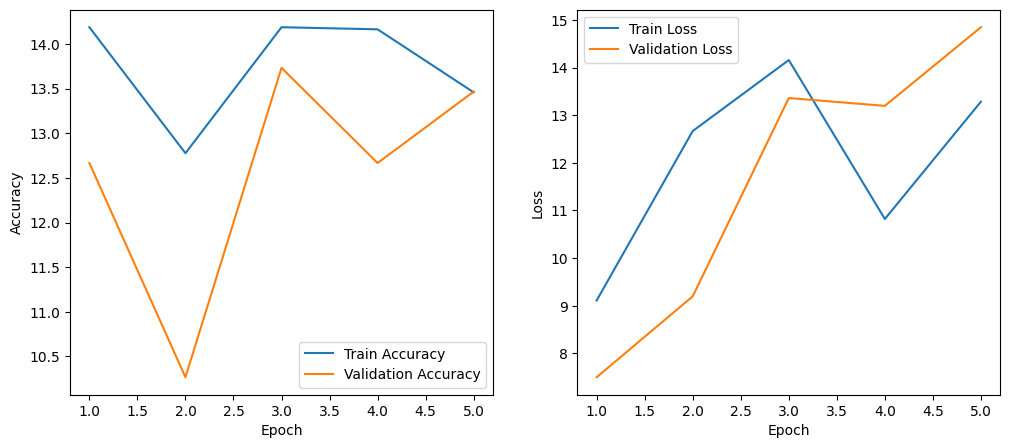

Starting training model: LogisticRegression with Adam and CrossEntropyLoss, 5 epochs
Epoch [1/5], Train Loss: 2.8104, Train Accuracy: 15.44%, Validation Loss: 2.4250, Validation Accuracy: 16.80%
Epoch [2/5], Train Loss: 2.3615, Train Accuracy: 18.00%, Validation Loss: 2.6222, Validation Accuracy: 12.80%
Epoch [3/5], Train Loss: 2.4782, Train Accuracy: 17.27%, Validation Loss: 2.5004, Validation Accuracy: 13.87%
Epoch [4/5], Train Loss: 2.4213, Train Accuracy: 17.32%, Validation Loss: 2.4047, Validation Accuracy: 16.53%
Epoch [5/5], Train Loss: 2.4635, Train Accuracy: 17.53%, Validation Loss: 2.6299, Validation Accuracy: 15.07%
Accuracy of the model on the test images: 17.04%


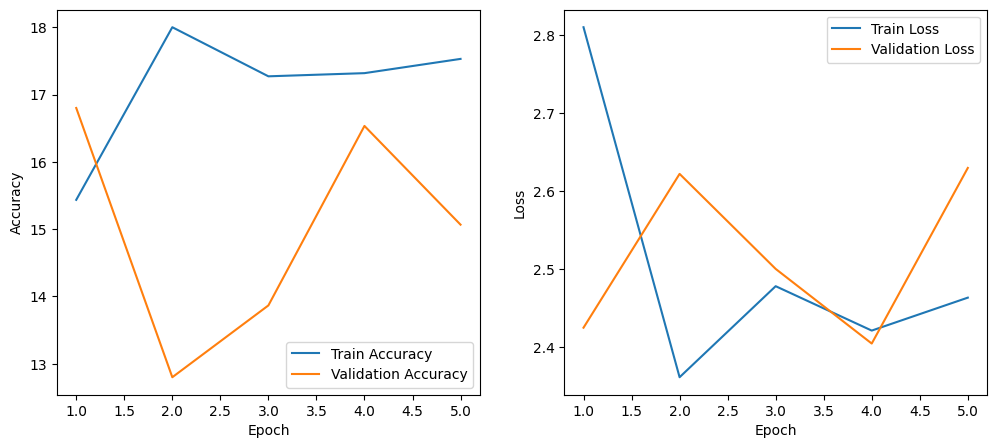

Starting training model: LogisticRegression with SGD and CrossEntropyLoss, 10 epochs
Epoch [1/10], Train Loss: 16.1084, Train Accuracy: 13.13%, Validation Loss: 6.2933, Validation Accuracy: 19.87%
Epoch [2/10], Train Loss: 10.7072, Train Accuracy: 14.64%, Validation Loss: 11.9162, Validation Accuracy: 18.13%
Epoch [3/10], Train Loss: 11.3966, Train Accuracy: 14.61%, Validation Loss: 8.4249, Validation Accuracy: 15.73%
Epoch [4/10], Train Loss: 10.3084, Train Accuracy: 14.31%, Validation Loss: 6.7572, Validation Accuracy: 13.47%
Epoch [5/10], Train Loss: 9.7962, Train Accuracy: 15.11%, Validation Loss: 12.9545, Validation Accuracy: 14.53%
Epoch [6/10], Train Loss: 12.8101, Train Accuracy: 14.02%, Validation Loss: 12.1741, Validation Accuracy: 17.33%
Epoch [7/10], Train Loss: 10.7473, Train Accuracy: 14.33%, Validation Loss: 14.4412, Validation Accuracy: 15.33%
Epoch [8/10], Train Loss: 10.8130, Train Accuracy: 15.32%, Validation Loss: 6.1887, Validation Accuracy: 21.33%
Epoch [9/10], Tr

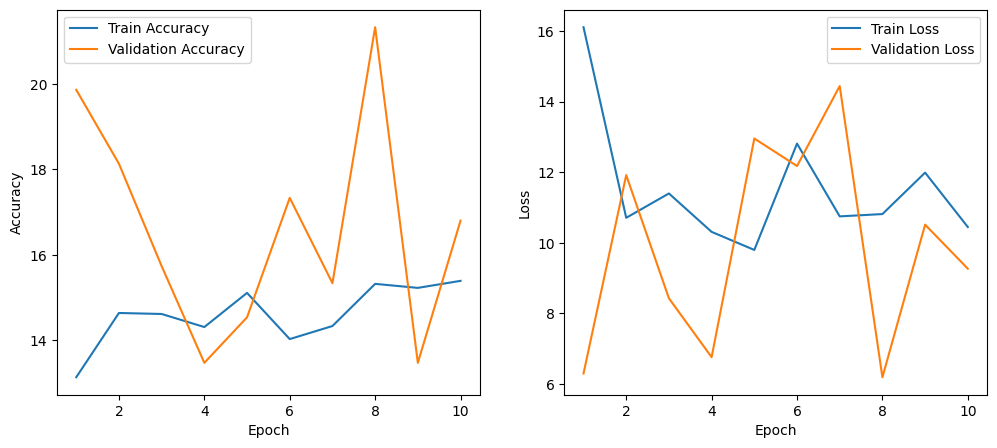

Starting training model: LogisticRegression with Adam and CrossEntropyLoss, 10 epochs
Epoch [1/10], Train Loss: 3.0272, Train Accuracy: 14.07%, Validation Loss: 2.3996, Validation Accuracy: 20.27%
Epoch [2/10], Train Loss: 2.4124, Train Accuracy: 17.29%, Validation Loss: 2.3973, Validation Accuracy: 18.80%
Epoch [3/10], Train Loss: 2.4654, Train Accuracy: 17.36%, Validation Loss: 2.3271, Validation Accuracy: 18.93%
Epoch [4/10], Train Loss: 2.3876, Train Accuracy: 17.81%, Validation Loss: 2.2072, Validation Accuracy: 19.47%
Epoch [5/10], Train Loss: 2.3794, Train Accuracy: 17.88%, Validation Loss: 2.7317, Validation Accuracy: 16.53%
Epoch [6/10], Train Loss: 2.6105, Train Accuracy: 17.11%, Validation Loss: 2.6918, Validation Accuracy: 16.00%
Epoch [7/10], Train Loss: 2.4176, Train Accuracy: 18.42%, Validation Loss: 2.4993, Validation Accuracy: 16.27%
Epoch [8/10], Train Loss: 2.4459, Train Accuracy: 19.08%, Validation Loss: 2.3978, Validation Accuracy: 17.60%
Epoch [9/10], Train Loss: 

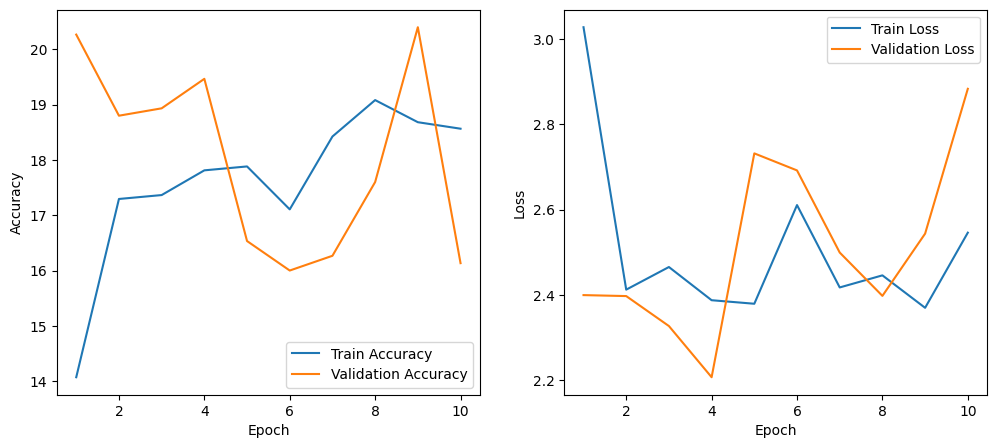

In [10]:
input_size = 3 * 64 * 64  # Example input size for 64x64 RGB images
num_classes = 10  # Adjust as needed
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

hyperparameters = [
    {'lr': 0.01, 'batch_size': 64, 'optimizer': 'SGD', 'num_epochs': 5},
    {'lr': 0.001, 'batch_size': 32, 'optimizer': 'Adam', 'num_epochs': 5},
    {'lr': 0.01, 'batch_size': 64, 'optimizer': 'SGD', 'num_epochs': 10},
    {'lr': 0.001, 'batch_size': 32, 'optimizer': 'Adam', 'num_epochs': 10},

]

for params in hyperparameters:
    Log_Reg_model = LogisticRegression(input_size, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    
    if params['optimizer'] == 'SGD':
        optimizer = optim.SGD(Log_Reg_model.parameters(), lr=params['lr'], momentum=0.9)
    elif params['optimizer'] == 'Adam':
        optimizer = optim.Adam(Log_Reg_model.parameters(), lr=params['lr'])

    train_acc, val_acc, train_loss, val_loss = train_and_evaluate(Log_Reg_model, train_loader, validation_loader, criterion, optimizer, params['num_epochs'])
    test_hyperparameter_tuned_log_reg_model(Log_Reg_model, test_loader, input_size, device)
    plot_curves(train_acc, val_acc, train_loss, val_loss)

2.  Fully-connected NN

In [11]:
def test_hyperparameter_tuned_nn_model(NN_model, test_loader, input_size, device):
    NN_model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            images = images.view(-1, input_size)

            outputs = NN_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Define the Fully Connected Neural Network
class FullyConnectedNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(FullyConnectedNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x



Test different configurations of hyperparameters

Starting training model: FullyConnectedNN with SGD and CrossEntropyLoss, 5 epochs
Epoch [1/5], Train Loss: 2.3067, Train Accuracy: 14.19%, Validation Loss: 2.1008, Validation Accuracy: 25.47%
Epoch [2/5], Train Loss: 2.1826, Train Accuracy: 18.96%, Validation Loss: 2.0499, Validation Accuracy: 25.20%
Epoch [3/5], Train Loss: 2.1457, Train Accuracy: 19.79%, Validation Loss: 2.0421, Validation Accuracy: 26.13%
Epoch [4/5], Train Loss: 2.0988, Train Accuracy: 21.76%, Validation Loss: 2.0538, Validation Accuracy: 23.60%
Epoch [5/5], Train Loss: 2.0932, Train Accuracy: 20.82%, Validation Loss: 2.0140, Validation Accuracy: 25.87%
Accuracy of the model on the test images: 29.91%


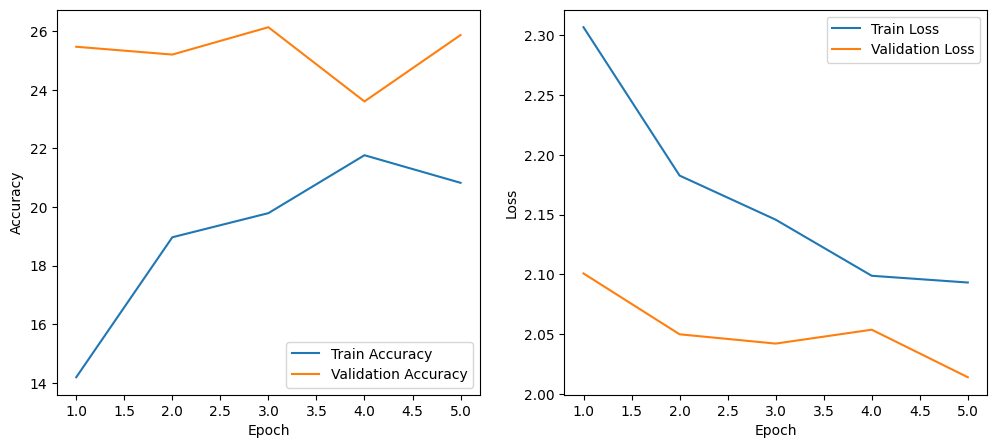

Starting training model: FullyConnectedNN with Adam and CrossEntropyLoss, 10 epochs
Epoch [1/10], Train Loss: 2.2700, Train Accuracy: 16.16%, Validation Loss: 2.0904, Validation Accuracy: 25.33%
Epoch [2/10], Train Loss: 2.1850, Train Accuracy: 19.29%, Validation Loss: 2.0580, Validation Accuracy: 24.53%
Epoch [3/10], Train Loss: 2.1095, Train Accuracy: 22.19%, Validation Loss: 1.9963, Validation Accuracy: 24.53%
Epoch [4/10], Train Loss: 2.0882, Train Accuracy: 21.44%, Validation Loss: 1.9917, Validation Accuracy: 26.93%
Epoch [5/10], Train Loss: 2.0434, Train Accuracy: 23.95%, Validation Loss: 1.9725, Validation Accuracy: 26.67%
Epoch [6/10], Train Loss: 2.0447, Train Accuracy: 23.88%, Validation Loss: 1.9603, Validation Accuracy: 28.13%
Epoch [7/10], Train Loss: 2.0316, Train Accuracy: 24.92%, Validation Loss: 1.9419, Validation Accuracy: 27.33%
Epoch [8/10], Train Loss: 2.0177, Train Accuracy: 25.08%, Validation Loss: 1.9463, Validation Accuracy: 27.33%
Epoch [9/10], Train Loss: 2.

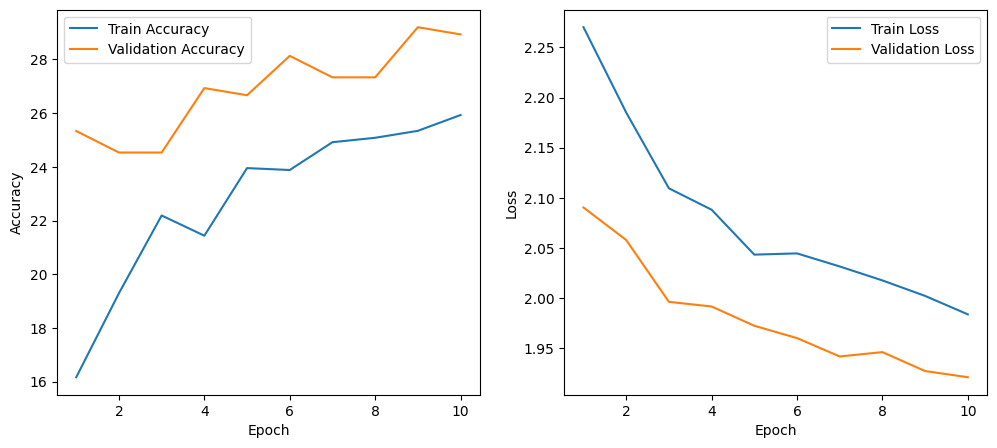

Starting training model: FullyConnectedNN with SGD and CrossEntropyLoss, 10 epochs
Epoch [1/10], Train Loss: 2.2721, Train Accuracy: 16.42%, Validation Loss: 2.0996, Validation Accuracy: 24.53%
Epoch [2/10], Train Loss: 2.1827, Train Accuracy: 19.55%, Validation Loss: 2.0795, Validation Accuracy: 23.60%
Epoch [3/10], Train Loss: 2.1402, Train Accuracy: 20.21%, Validation Loss: 2.0116, Validation Accuracy: 26.53%
Epoch [4/10], Train Loss: 2.1063, Train Accuracy: 21.32%, Validation Loss: 2.0309, Validation Accuracy: 23.60%
Epoch [5/10], Train Loss: 2.0831, Train Accuracy: 22.64%, Validation Loss: 1.9949, Validation Accuracy: 24.13%
Epoch [6/10], Train Loss: 2.0826, Train Accuracy: 22.64%, Validation Loss: 1.9822, Validation Accuracy: 28.13%
Epoch [7/10], Train Loss: 2.0660, Train Accuracy: 22.56%, Validation Loss: 1.9993, Validation Accuracy: 27.07%
Epoch [8/10], Train Loss: 2.0591, Train Accuracy: 23.67%, Validation Loss: 1.9720, Validation Accuracy: 29.33%
Epoch [9/10], Train Loss: 2.0

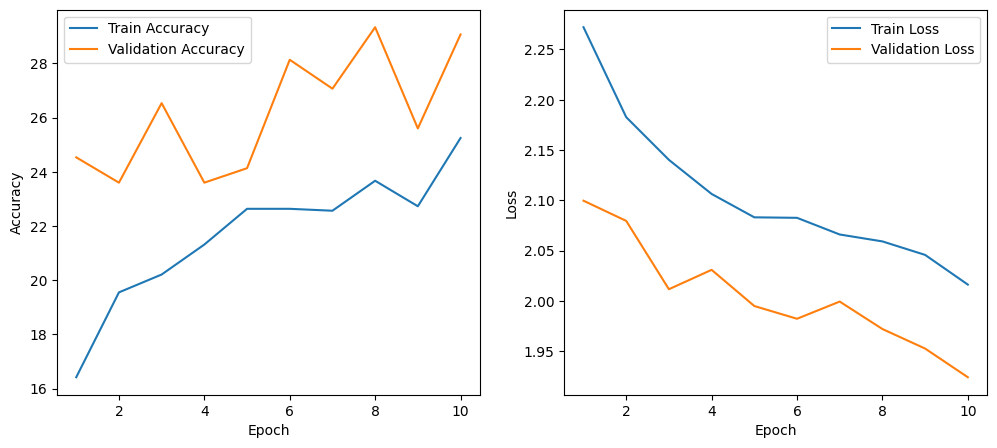

Starting training model: FullyConnectedNN with Adam and CrossEntropyLoss, 15 epochs
Epoch [1/15], Train Loss: 2.2885, Train Accuracy: 15.25%, Validation Loss: 2.1131, Validation Accuracy: 21.47%
Epoch [2/15], Train Loss: 2.1700, Train Accuracy: 20.26%, Validation Loss: 2.0607, Validation Accuracy: 24.67%
Epoch [3/15], Train Loss: 2.1306, Train Accuracy: 21.86%, Validation Loss: 2.0036, Validation Accuracy: 24.93%
Epoch [4/15], Train Loss: 2.0775, Train Accuracy: 22.85%, Validation Loss: 2.0172, Validation Accuracy: 26.53%
Epoch [5/15], Train Loss: 2.0767, Train Accuracy: 22.59%, Validation Loss: 1.9870, Validation Accuracy: 28.13%
Epoch [6/15], Train Loss: 2.0401, Train Accuracy: 23.25%, Validation Loss: 1.9831, Validation Accuracy: 25.73%
Epoch [7/15], Train Loss: 2.0201, Train Accuracy: 25.41%, Validation Loss: 1.9566, Validation Accuracy: 28.53%
Epoch [8/15], Train Loss: 2.0096, Train Accuracy: 25.58%, Validation Loss: 1.9811, Validation Accuracy: 26.67%
Epoch [9/15], Train Loss: 1.

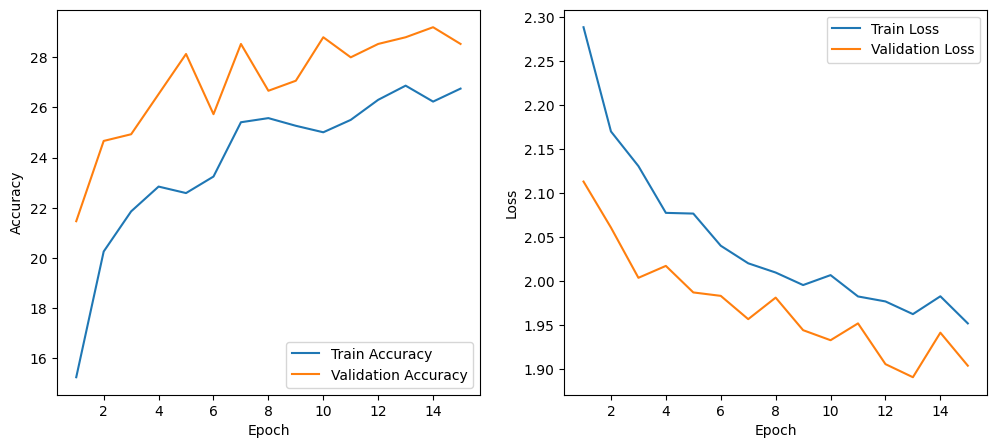

Starting training model: FullyConnectedNN with Adam and CrossEntropyLoss, 20 epochs
Epoch [1/20], Train Loss: 2.2695, Train Accuracy: 15.81%, Validation Loss: 2.1123, Validation Accuracy: 22.67%
Epoch [2/20], Train Loss: 2.1711, Train Accuracy: 19.22%, Validation Loss: 2.0762, Validation Accuracy: 22.80%
Epoch [3/20], Train Loss: 2.1067, Train Accuracy: 21.76%, Validation Loss: 2.0050, Validation Accuracy: 24.93%
Epoch [4/20], Train Loss: 2.0830, Train Accuracy: 22.09%, Validation Loss: 2.0562, Validation Accuracy: 24.40%
Epoch [5/20], Train Loss: 2.0604, Train Accuracy: 23.48%, Validation Loss: 1.9963, Validation Accuracy: 28.40%
Epoch [6/20], Train Loss: 2.0405, Train Accuracy: 23.69%, Validation Loss: 2.0317, Validation Accuracy: 25.87%
Epoch [7/20], Train Loss: 2.0198, Train Accuracy: 24.61%, Validation Loss: 1.9851, Validation Accuracy: 26.80%
Epoch [8/20], Train Loss: 2.0135, Train Accuracy: 26.00%, Validation Loss: 1.9218, Validation Accuracy: 28.27%
Epoch [9/20], Train Loss: 1.

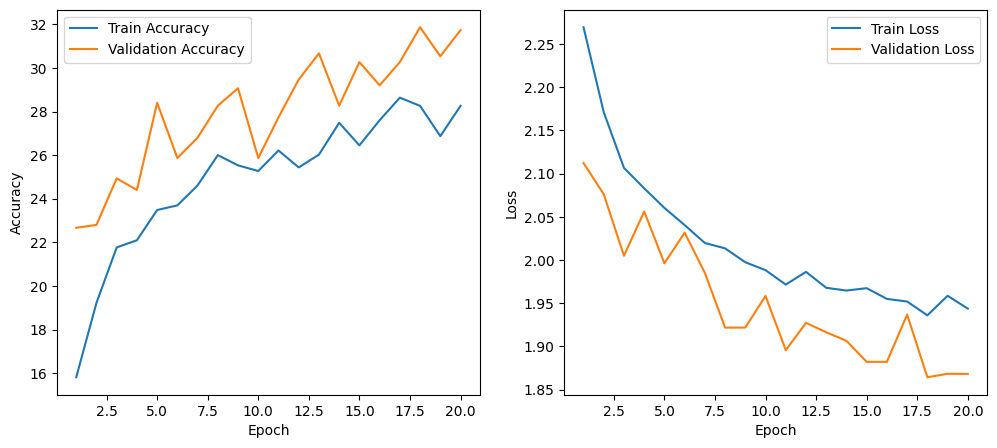

In [13]:
# Fixed parameters
input_size = 3 * 64 * 64  # Example input size for 64x64 RGB images
num_classes = 10  # Adjust as needed
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

hyperparameters = [
    {'lr': 0.01, 'batch_size': 64, 'optimizer': 'SGD', 'num_epochs': 5},
    {'lr': 0.001, 'batch_size': 32, 'optimizer': 'Adam', 'num_epochs': 10},
    {'lr': 0.01, 'batch_size': 64, 'optimizer': 'SGD', 'num_epochs': 10},
    {'lr': 0.001, 'batch_size': 32, 'optimizer': 'Adam', 'num_epochs': 15},
    {'lr': 0.001, 'batch_size': 32, 'optimizer': 'Adam', 'num_epochs': 20},
]

for params in hyperparameters:

    NN_model = FullyConnectedNN(input_size, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()

    if params['optimizer'] == 'SGD':
        optimizer = optim.SGD(NN_model.parameters(), lr=params['lr'], momentum=0.9)
    elif params['optimizer'] == 'Adam':
        optimizer = optim.Adam(NN_model.parameters(), lr=params['lr'])

    train_acc, val_acc, train_loss, val_loss = train_and_evaluate(NN_model, train_loader, validation_loader, criterion, optimizer, params['num_epochs'])
    test_hyperparameter_tuned_nn_model(NN_model, test_loader, input_size, device)
    plot_curves(train_acc, val_acc, train_loss, val_loss)



3. CNN

In [14]:
def train_and_evaluate_CNN(model, train_loader, validation_loader, criterion, optimizer, num_epochs):
    train_acc = []
    val_acc = []
    train_loss = []
    val_loss = []

    for epoch in range(num_epochs):
        model.train()
        correct = 0
        total = 0
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Ensure images have 4D shape and labels are tensors
            if images.dim() == 3:  # If single image, add batch dimension
                images = images.unsqueeze(0)
            elif images.dim() == 2:  # If missing channel dimension, expand it (assuming grayscale images)
                images = images.unsqueeze(1)  # Add channel dimension

            if isinstance(labels, int):  # If labels are single integers, convert them to tensors
                labels = torch.tensor(labels).to(device)



            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss.append(running_loss / len(train_loader))
        train_acc.append(100 * correct / total)

        model.eval()
        correct = 0
        total = 0
        running_loss = 0.0  # Initialize running_loss to 0 for each epoch

        with torch.no_grad():
            for images, labels in validation_loader:
                images = images.to(device)
                labels = torch.tensor(labels).to(device)
                images = images.view(-1, 3, 64, 64)

                if len(labels.shape) == 0:
                  labels = labels.unsqueeze(0)

                outputs = CNN_model(images)
                running_loss += criterion(outputs, labels).item() # accumulate validation loss per batch

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss.append(running_loss / len(validation_loader)) # append average validation loss for the epoch
        val_acc.append(100 * correct / total)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss[-1]:.4f}, Train Accuracy: {train_acc[-1]:.2f}%, Validation Loss: {val_loss[-1]:.4f}, Validation Accuracy: {val_acc[-1]:.2f}%')

    return train_acc, val_acc, train_loss, val_loss

def plot_curves(train_acc, val_acc, train_loss, val_loss):
    epochs = range(1, len(train_acc) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

def test_hyperparameter_tuned_cnn_model(CNN_model, test_loader, device):
      CNN_model.eval()
      with torch.no_grad():
          correct = 0
          total = 0
          for images, labels in test_loader:
              images = images.to(device)
              labels = labels.to(device)

              outputs = CNN_model(images)
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

          print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')

Epoch [1/5], Train Loss: 2.2136, Train Accuracy: 15.41%, Validation Loss: 2.0911, Validation Accuracy: 18.93%
Epoch [2/5], Train Loss: 2.0292, Train Accuracy: 22.14%, Validation Loss: 1.8778, Validation Accuracy: 25.60%
Epoch [3/5], Train Loss: 1.9327, Train Accuracy: 24.05%, Validation Loss: 1.8985, Validation Accuracy: 24.80%
Epoch [4/5], Train Loss: 1.9010, Train Accuracy: 25.04%, Validation Loss: 1.8084, Validation Accuracy: 28.53%
Epoch [5/5], Train Loss: 1.8895, Train Accuracy: 25.29%, Validation Loss: 1.8644, Validation Accuracy: 26.40%
Accuracy of the model on the test images: 29.04%


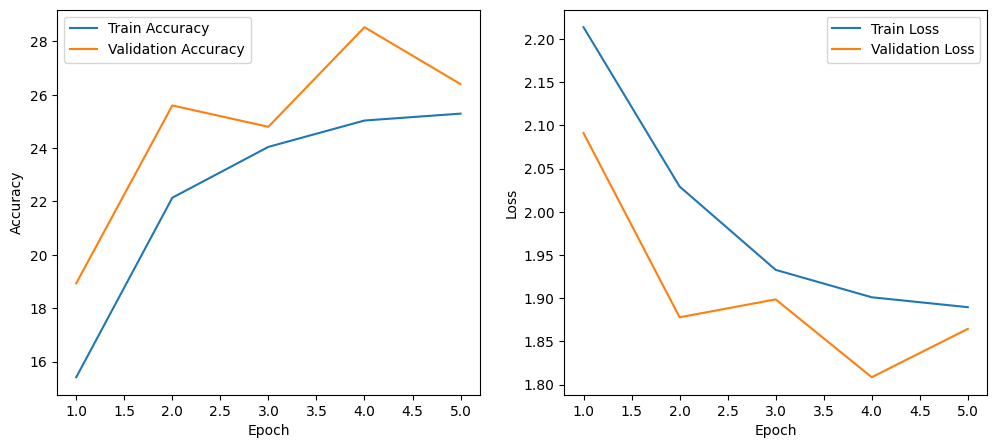

Epoch [1/15], Train Loss: 2.4618, Train Accuracy: 13.67%, Validation Loss: 2.1550, Validation Accuracy: 24.67%
Epoch [2/15], Train Loss: 2.1925, Train Accuracy: 18.52%, Validation Loss: 2.0633, Validation Accuracy: 23.73%
Epoch [3/15], Train Loss: 2.0935, Train Accuracy: 20.00%, Validation Loss: 2.0081, Validation Accuracy: 25.33%
Epoch [4/15], Train Loss: 1.9707, Train Accuracy: 22.12%, Validation Loss: 1.8321, Validation Accuracy: 27.33%
Epoch [5/15], Train Loss: 1.9057, Train Accuracy: 24.56%, Validation Loss: 1.9474, Validation Accuracy: 26.67%
Epoch [6/15], Train Loss: 1.8956, Train Accuracy: 24.94%, Validation Loss: 1.8030, Validation Accuracy: 26.40%
Epoch [7/15], Train Loss: 1.8467, Train Accuracy: 25.25%, Validation Loss: 1.8354, Validation Accuracy: 28.00%
Epoch [8/15], Train Loss: 1.8245, Train Accuracy: 27.04%, Validation Loss: 1.7818, Validation Accuracy: 30.13%
Epoch [9/15], Train Loss: 1.8215, Train Accuracy: 26.40%, Validation Loss: 2.0152, Validation Accuracy: 27.60%
E

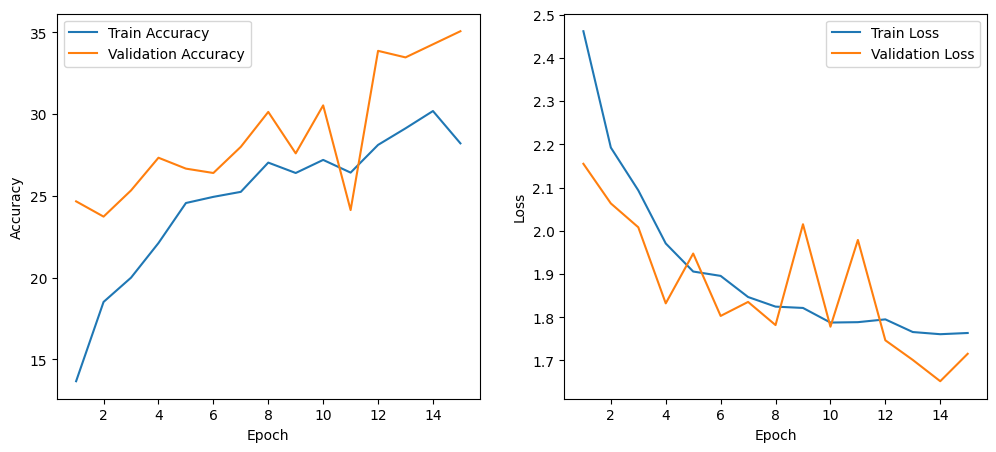

Epoch [1/10], Train Loss: 2.2439, Train Accuracy: 15.98%, Validation Loss: 2.0504, Validation Accuracy: 25.60%
Epoch [2/10], Train Loss: 2.0405, Train Accuracy: 22.61%, Validation Loss: 2.0518, Validation Accuracy: 24.80%
Epoch [3/10], Train Loss: 1.9780, Train Accuracy: 22.78%, Validation Loss: 1.9093, Validation Accuracy: 24.67%
Epoch [4/10], Train Loss: 1.9087, Train Accuracy: 24.12%, Validation Loss: 2.0077, Validation Accuracy: 25.73%
Epoch [5/10], Train Loss: 1.9051, Train Accuracy: 25.58%, Validation Loss: 1.8366, Validation Accuracy: 26.53%
Epoch [6/10], Train Loss: 1.8668, Train Accuracy: 26.42%, Validation Loss: 1.8413, Validation Accuracy: 27.33%
Epoch [7/10], Train Loss: 1.8982, Train Accuracy: 23.95%, Validation Loss: 1.8401, Validation Accuracy: 24.27%
Epoch [8/10], Train Loss: 1.8632, Train Accuracy: 25.72%, Validation Loss: 1.7565, Validation Accuracy: 35.73%
Epoch [9/10], Train Loss: 1.8352, Train Accuracy: 26.85%, Validation Loss: 1.9309, Validation Accuracy: 28.00%
E

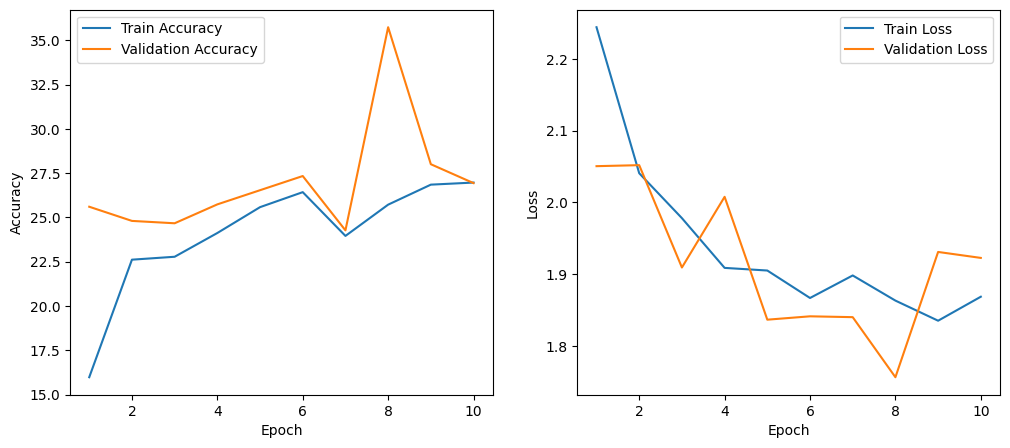

Epoch [1/20], Train Loss: 2.4904, Train Accuracy: 12.54%, Validation Loss: 2.2495, Validation Accuracy: 17.47%
Epoch [2/20], Train Loss: 2.2209, Train Accuracy: 16.09%, Validation Loss: 2.1479, Validation Accuracy: 21.87%
Epoch [3/20], Train Loss: 2.1329, Train Accuracy: 20.09%, Validation Loss: 2.0409, Validation Accuracy: 22.53%
Epoch [4/20], Train Loss: 2.0562, Train Accuracy: 20.75%, Validation Loss: 1.9374, Validation Accuracy: 21.07%
Epoch [5/20], Train Loss: 1.9575, Train Accuracy: 22.71%, Validation Loss: 1.8384, Validation Accuracy: 24.00%
Epoch [6/20], Train Loss: 1.8929, Train Accuracy: 23.95%, Validation Loss: 1.8080, Validation Accuracy: 28.00%
Epoch [7/20], Train Loss: 1.8641, Train Accuracy: 24.73%, Validation Loss: 1.8024, Validation Accuracy: 31.87%
Epoch [8/20], Train Loss: 1.8338, Train Accuracy: 26.87%, Validation Loss: 1.9698, Validation Accuracy: 25.73%
Epoch [9/20], Train Loss: 1.8349, Train Accuracy: 25.36%, Validation Loss: 2.0646, Validation Accuracy: 23.60%
E

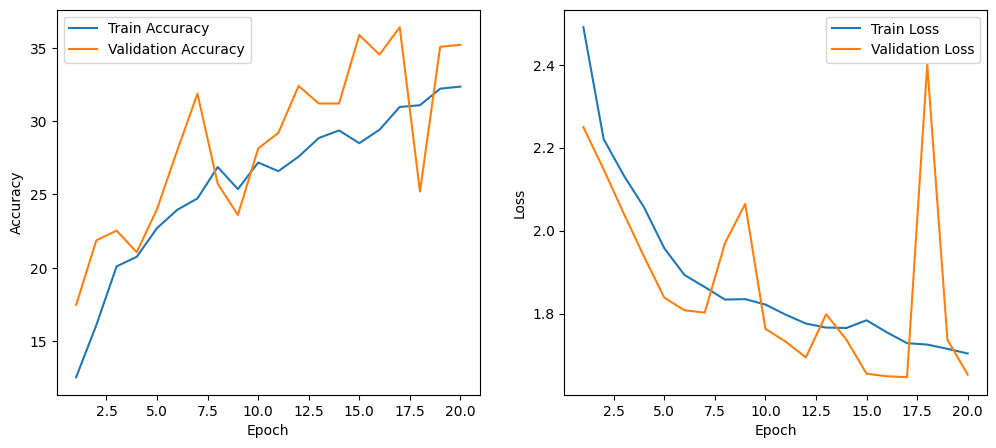

In [15]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.dropout2(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

# Hyperparameters
num_classes = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hyperparameters = [
    {'lr': 0.01, 'batch_size': 64, 'optimizer': 'SGD', 'num_epochs':5},
    {'lr': 0.001, 'batch_size': 32, 'optimizer': 'Adam', 'num_epochs': 15},
    {'lr': 0.01, 'batch_size': 64, 'optimizer': 'SGD', 'num_epochs': 10},
    {'lr': 0.001, 'batch_size': 32, 'optimizer': 'Adam', 'num_epochs': 20},

]

for params in hyperparameters:

    CNN_model = CNN(num_classes).to(device)
    criterion = nn.CrossEntropyLoss()

    if params['optimizer'] == 'SGD':
        optimizer = optim.SGD(CNN_model.parameters(), lr=params['lr'], momentum=0.9)
    elif params['optimizer'] == 'Adam':
        optimizer = optim.Adam(CNN_model.parameters(), lr=params['lr'])

    train_acc, val_acc, train_loss, val_loss = train_and_evaluate_CNN(CNN_model, train_loader, validation_loader, criterion, optimizer, params['num_epochs'])
    test_hyperparameter_tuned_cnn_model(CNN_model, test_loader, device)
    plot_curves(train_acc, val_acc, train_loss, val_loss)



4. A fixed pre-trained MobileNetV2

Test, Train, and Plot functions

In [16]:
def train_and_evaluate_mobilenet(model, train_loader, validation_loader, criterion, optimizer, num_epochs, device):
    train_acc = []
    val_acc = []
    train_loss = []
    val_loss = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Ensure images have a batch dimension
            if images.dim() == 3:
                images = images.unsqueeze(0)  # Convert (C, H, W) -> (1, C, H, W)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss.append(running_loss / len(train_loader))
        train_acc.append(100 * correct / total)

        model.eval()
        val_loss_epoch = 0.0  # Initialize val_loss for the epoch
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in validation_loader:
                images = images.to(device)
                labels = torch.tensor(labels).to(device)  # Convert labels to tensor
                images = images.view(-1, 3, 64, 64)  # Reshape for MobileNetV2

                if len(labels.shape) == 0:
                    labels = labels.unsqueeze(0)

                outputs = model(images)
                val_loss_epoch += criterion(outputs, labels).item()  # Accumulate loss

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss.append(val_loss_epoch / len(validation_loader))  # Append average loss for the epoch
        val_acc.append(100 * correct / total)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss[-1]:.4f}, Train Accuracy: {train_acc[-1]:.2f}%, Validation Loss: {val_loss[-1]:.4f}, Validation Accuracy: {val_acc[-1]:.2f}%')

    return train_acc, val_acc, train_loss, val_loss


def test_model_mobilenet(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on test images: {100 * correct / total:.2f}%')


establishing and training

C:\Users\ASUS\AppData\Roaming\Python\Python37\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\ASUS\AppData\Roaming\Python\Python37\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/5], Train Loss: 1.9445, Train Accuracy: 33.34%, Validation Loss: 1.3683, Validation Accuracy: 51.07%
Epoch [2/5], Train Loss: 1.2704, Train Accuracy: 54.85%, Validation Loss: 1.1379, Validation Accuracy: 60.80%
Epoch [3/5], Train Loss: 1.1168, Train Accuracy: 60.80%, Validation Loss: 1.1394, Validation Accuracy: 60.27%
Epoch [4/5], Train Loss: 1.0766, Train Accuracy: 61.88%, Validation Loss: 1.0874, Validation Accuracy: 61.47%
Epoch [5/5], Train Loss: 1.0535, Train Accuracy: 62.49%, Validation Loss: 1.0155, Validation Accuracy: 66.27%
Accuracy of the model on test images: 68.22%


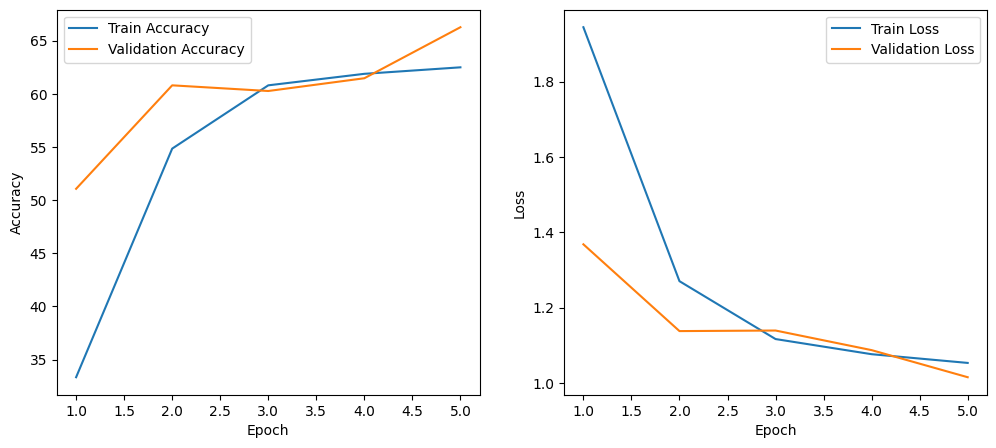

Epoch [1/15], Train Loss: 1.0738, Train Accuracy: 60.80%, Validation Loss: 0.9653, Validation Accuracy: 66.27%
Epoch [2/15], Train Loss: 1.0140, Train Accuracy: 63.74%, Validation Loss: 1.0383, Validation Accuracy: 62.67%
Epoch [3/15], Train Loss: 1.0186, Train Accuracy: 64.42%, Validation Loss: 1.0069, Validation Accuracy: 64.13%
Epoch [4/15], Train Loss: 0.9584, Train Accuracy: 66.68%, Validation Loss: 1.0387, Validation Accuracy: 61.47%
Epoch [5/15], Train Loss: 0.9728, Train Accuracy: 65.55%, Validation Loss: 0.9712, Validation Accuracy: 66.00%
Epoch [6/15], Train Loss: 0.9468, Train Accuracy: 66.54%, Validation Loss: 1.0655, Validation Accuracy: 63.47%
Epoch [7/15], Train Loss: 0.9636, Train Accuracy: 65.34%, Validation Loss: 1.0089, Validation Accuracy: 64.67%
Epoch [8/15], Train Loss: 0.9542, Train Accuracy: 66.68%, Validation Loss: 1.0212, Validation Accuracy: 64.93%
Epoch [9/15], Train Loss: 0.9248, Train Accuracy: 66.75%, Validation Loss: 0.9809, Validation Accuracy: 64.93%
E

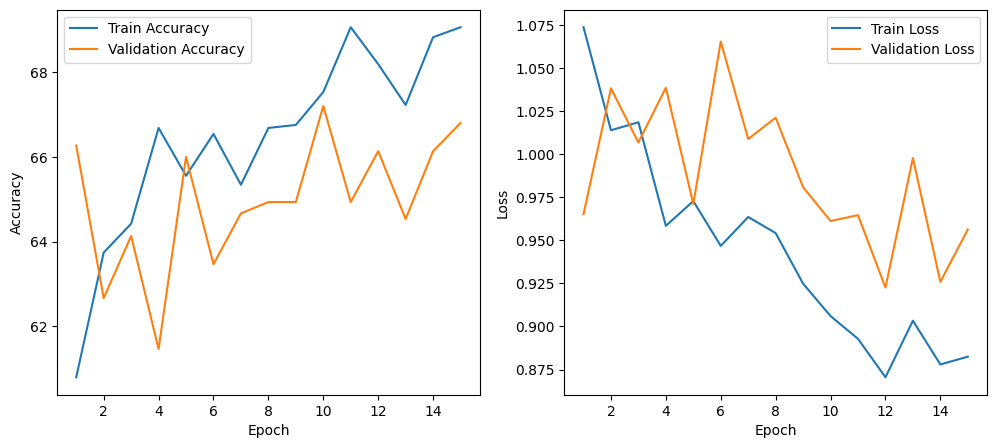

Epoch [1/10], Train Loss: 0.8320, Train Accuracy: 70.56%, Validation Loss: 0.9027, Validation Accuracy: 66.40%
Epoch [2/10], Train Loss: 0.8257, Train Accuracy: 70.42%, Validation Loss: 0.8637, Validation Accuracy: 70.40%
Epoch [3/10], Train Loss: 0.8509, Train Accuracy: 70.00%, Validation Loss: 0.9020, Validation Accuracy: 66.27%
Epoch [4/10], Train Loss: 0.7920, Train Accuracy: 70.99%, Validation Loss: 0.9080, Validation Accuracy: 68.93%
Epoch [5/10], Train Loss: 0.8116, Train Accuracy: 70.59%, Validation Loss: 0.9216, Validation Accuracy: 68.40%
Epoch [6/10], Train Loss: 0.8105, Train Accuracy: 71.69%, Validation Loss: 0.8816, Validation Accuracy: 68.80%
Epoch [7/10], Train Loss: 0.7836, Train Accuracy: 72.35%, Validation Loss: 0.9600, Validation Accuracy: 66.00%
Epoch [8/10], Train Loss: 0.7928, Train Accuracy: 71.69%, Validation Loss: 0.9538, Validation Accuracy: 66.67%
Epoch [9/10], Train Loss: 0.8250, Train Accuracy: 70.45%, Validation Loss: 0.9770, Validation Accuracy: 65.73%
E

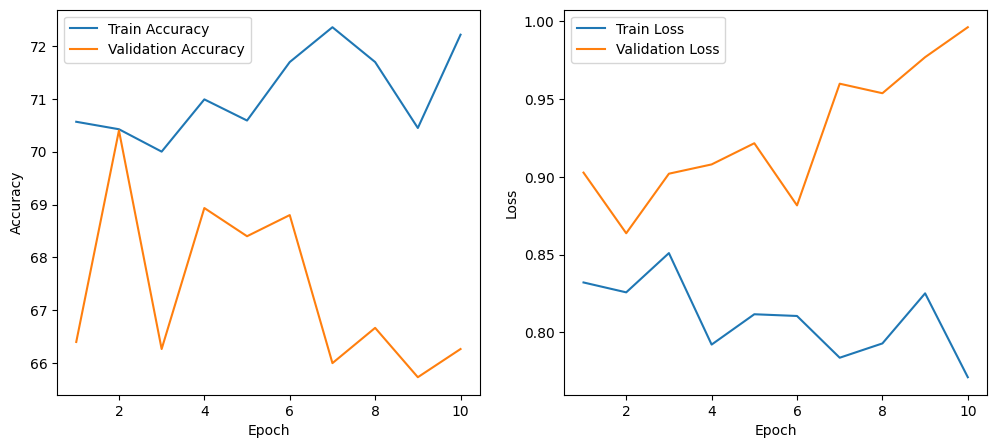

Epoch [1/20], Train Loss: 0.8568, Train Accuracy: 68.85%, Validation Loss: 0.9640, Validation Accuracy: 65.33%
Epoch [2/20], Train Loss: 0.8573, Train Accuracy: 68.87%, Validation Loss: 0.9357, Validation Accuracy: 67.47%
Epoch [3/20], Train Loss: 0.8156, Train Accuracy: 70.89%, Validation Loss: 1.0447, Validation Accuracy: 64.93%
Epoch [4/20], Train Loss: 0.8423, Train Accuracy: 69.41%, Validation Loss: 0.9436, Validation Accuracy: 67.47%
Epoch [5/20], Train Loss: 0.8132, Train Accuracy: 71.60%, Validation Loss: 0.9925, Validation Accuracy: 64.27%
Epoch [6/20], Train Loss: 0.7991, Train Accuracy: 71.84%, Validation Loss: 0.9999, Validation Accuracy: 65.60%
Epoch [7/20], Train Loss: 0.7913, Train Accuracy: 71.91%, Validation Loss: 0.9360, Validation Accuracy: 67.73%
Epoch [8/20], Train Loss: 0.8246, Train Accuracy: 70.96%, Validation Loss: 0.8985, Validation Accuracy: 67.60%
Epoch [9/20], Train Loss: 0.8214, Train Accuracy: 70.19%, Validation Loss: 0.8672, Validation Accuracy: 68.53%
E

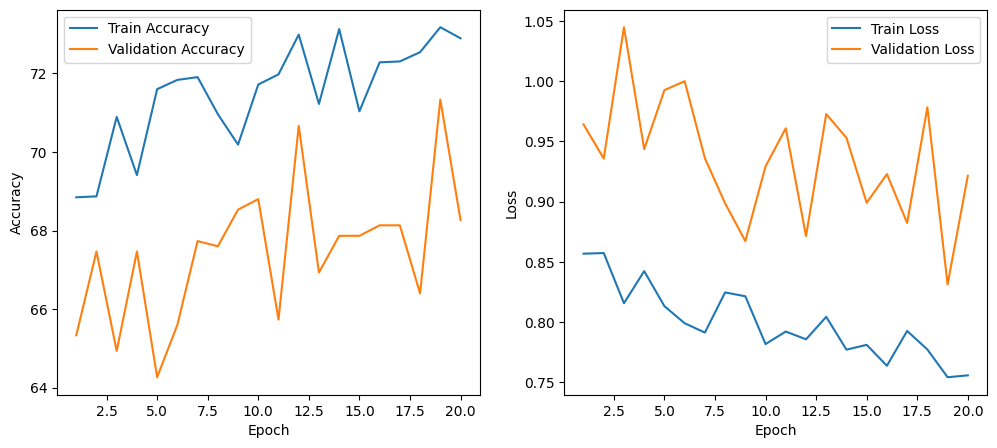

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms

# Load pre-trained MobileNetV2
mobilenet = models.mobilenet_v2(pretrained=True)

# Freeze all layers
for param in mobilenet.parameters():
    param.requires_grad = False

# Modify the classifier
num_ftrs = mobilenet.classifier[1].in_features
mobilenet.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(True),
    nn.Linear(256, 128),
    nn.ReLU(True),
    nn.Linear(128, 10)  # 10 classes
)

# Move the model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet = mobilenet.to(device)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Hyperparameters
hyperparameters = [
    {'lr': 0.01, 'batch_size': 64, 'optimizer': 'SGD', 'num_epochs': 5},
    {'lr': 0.001, 'batch_size': 32, 'optimizer': 'Adam', 'num_epochs': 15},
    {'lr': 0.01, 'batch_size': 64, 'optimizer': 'SGD', 'num_epochs': 10},
    {'lr': 0.001, 'batch_size': 32, 'optimizer': 'Adam', 'num_epochs': 20},

]

for params in hyperparameters:

    # Define optimizer
    if params['optimizer'] == 'SGD':
        optimizer = optim.SGD(mobilenet.classifier.parameters(), lr=params['lr'], momentum=0.9)
    elif params['optimizer'] == 'Adam':
        optimizer = optim.Adam(mobilenet.classifier.parameters(), lr=params['lr'])

    # Train and evaluate the model
    train_acc, val_acc, train_loss, val_loss = train_and_evaluate_mobilenet(mobilenet, train_loader, validation_loader, criterion, optimizer, params['num_epochs'], device)
    test_model_mobilenet(mobilenet, test_loader, device)
    plot_curves(train_acc, val_acc, train_loss, val_loss)




5. A learned pre-trained MobileNetV2

Establishing and training

Epoch [1/5], Train Loss: 1.9716, Train Accuracy: 31.06%, Validation Loss: 1.3614, Validation Accuracy: 52.00%
Epoch [2/5], Train Loss: 1.2461, Train Accuracy: 55.25%, Validation Loss: 1.1595, Validation Accuracy: 58.53%
Epoch [3/5], Train Loss: 1.1150, Train Accuracy: 60.47%, Validation Loss: 1.0730, Validation Accuracy: 63.20%
Epoch [4/5], Train Loss: 1.0657, Train Accuracy: 62.45%, Validation Loss: 1.0009, Validation Accuracy: 65.07%
Epoch [5/5], Train Loss: 1.0411, Train Accuracy: 64.24%, Validation Loss: 1.0523, Validation Accuracy: 62.93%
Accuracy of the model on test images: 68.46%


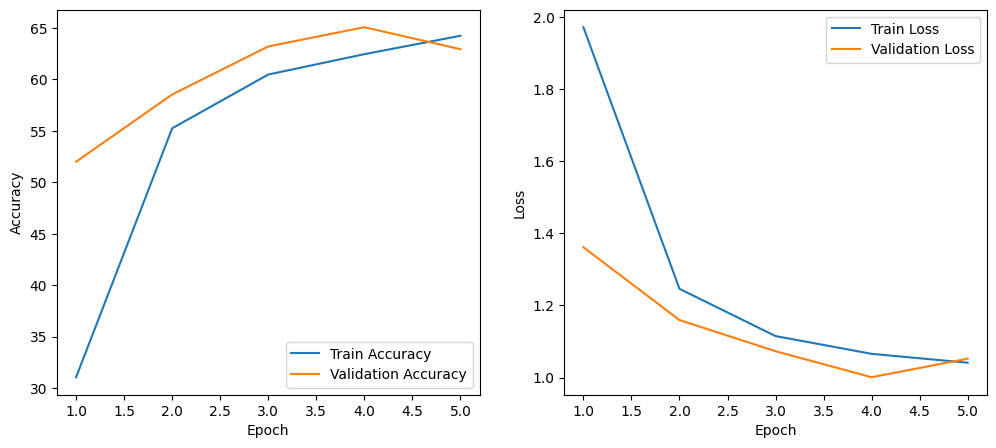

Epoch [1/15], Train Loss: 1.0890, Train Accuracy: 61.53%, Validation Loss: 0.9989, Validation Accuracy: 63.33%
Epoch [2/15], Train Loss: 1.0146, Train Accuracy: 64.02%, Validation Loss: 1.0095, Validation Accuracy: 64.67%
Epoch [3/15], Train Loss: 1.0105, Train Accuracy: 64.21%, Validation Loss: 1.0064, Validation Accuracy: 65.07%
Epoch [4/15], Train Loss: 1.0030, Train Accuracy: 64.52%, Validation Loss: 0.9333, Validation Accuracy: 68.40%
Epoch [5/15], Train Loss: 0.9650, Train Accuracy: 66.31%, Validation Loss: 0.9924, Validation Accuracy: 62.93%
Epoch [6/15], Train Loss: 0.9505, Train Accuracy: 66.28%, Validation Loss: 0.9910, Validation Accuracy: 63.33%
Epoch [7/15], Train Loss: 0.9561, Train Accuracy: 66.14%, Validation Loss: 1.0190, Validation Accuracy: 63.07%
Epoch [8/15], Train Loss: 0.9309, Train Accuracy: 67.13%, Validation Loss: 1.0584, Validation Accuracy: 62.27%
Epoch [9/15], Train Loss: 0.9200, Train Accuracy: 66.99%, Validation Loss: 0.9291, Validation Accuracy: 65.33%
E

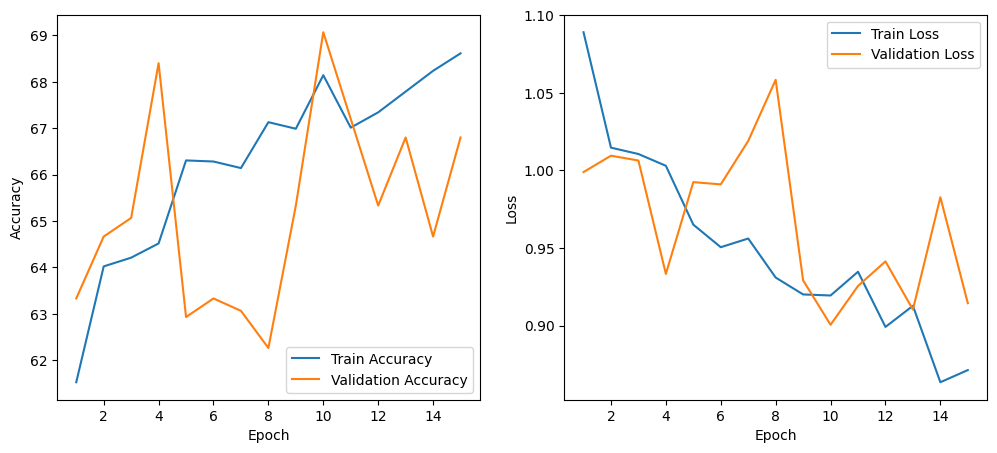

Epoch [1/10], Train Loss: 0.8590, Train Accuracy: 68.94%, Validation Loss: 0.9445, Validation Accuracy: 66.40%
Epoch [2/10], Train Loss: 0.8164, Train Accuracy: 70.96%, Validation Loss: 0.9502, Validation Accuracy: 66.53%
Epoch [3/10], Train Loss: 0.8335, Train Accuracy: 69.41%, Validation Loss: 0.9417, Validation Accuracy: 69.20%
Epoch [4/10], Train Loss: 0.8152, Train Accuracy: 70.49%, Validation Loss: 0.9245, Validation Accuracy: 67.73%
Epoch [5/10], Train Loss: 0.8339, Train Accuracy: 70.14%, Validation Loss: 0.9151, Validation Accuracy: 67.07%
Epoch [6/10], Train Loss: 0.8237, Train Accuracy: 70.38%, Validation Loss: 0.9427, Validation Accuracy: 65.33%
Epoch [7/10], Train Loss: 0.8084, Train Accuracy: 71.06%, Validation Loss: 0.9508, Validation Accuracy: 67.87%
Epoch [8/10], Train Loss: 0.7997, Train Accuracy: 71.36%, Validation Loss: 0.9218, Validation Accuracy: 67.07%
Epoch [9/10], Train Loss: 0.8120, Train Accuracy: 71.29%, Validation Loss: 0.9001, Validation Accuracy: 69.20%
E

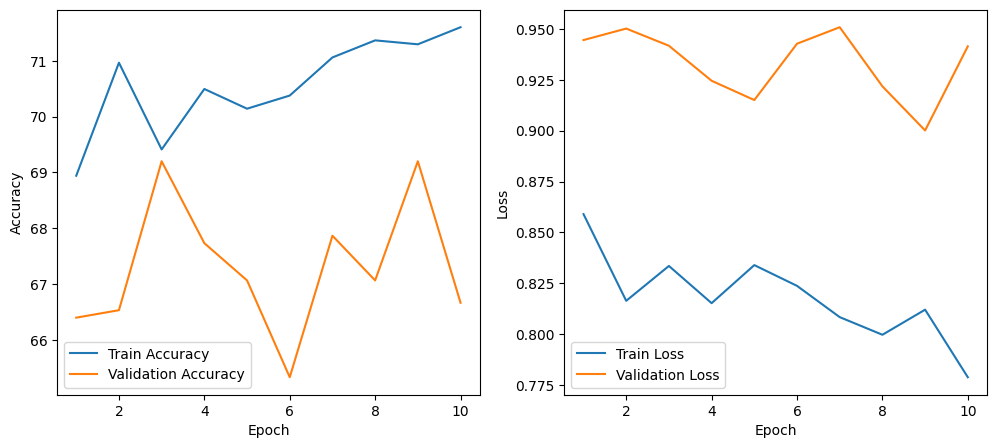

Epoch [1/20], Train Loss: 0.8542, Train Accuracy: 70.26%, Validation Loss: 0.9777, Validation Accuracy: 64.67%
Epoch [2/20], Train Loss: 0.8286, Train Accuracy: 70.19%, Validation Loss: 0.9506, Validation Accuracy: 66.40%
Epoch [3/20], Train Loss: 0.8059, Train Accuracy: 71.13%, Validation Loss: 0.9063, Validation Accuracy: 68.40%
Epoch [4/20], Train Loss: 0.7993, Train Accuracy: 72.71%, Validation Loss: 0.9939, Validation Accuracy: 63.33%
Epoch [5/20], Train Loss: 0.8167, Train Accuracy: 70.99%, Validation Loss: 0.9564, Validation Accuracy: 65.07%
Epoch [6/20], Train Loss: 0.8389, Train Accuracy: 70.42%, Validation Loss: 0.9041, Validation Accuracy: 66.80%
Epoch [7/20], Train Loss: 0.8206, Train Accuracy: 70.52%, Validation Loss: 0.9036, Validation Accuracy: 66.53%
Epoch [8/20], Train Loss: 0.7934, Train Accuracy: 71.20%, Validation Loss: 0.9012, Validation Accuracy: 69.47%
Epoch [9/20], Train Loss: 0.8186, Train Accuracy: 70.49%, Validation Loss: 0.9590, Validation Accuracy: 67.87%
E

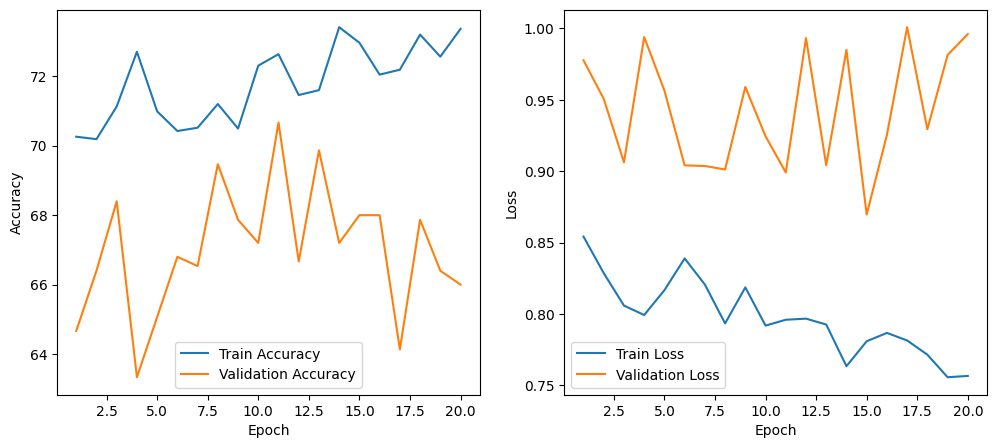

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# Load pre-trained MobileNetV2 and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet_v2 = models.mobilenet_v2(pretrained=True).to(device)

# Modify the classifier for 10 classes
num_ftrs = mobilenet_v2.classifier[1].in_features
mobilenet_v2.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(inplace=True),
    nn.Linear(256, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 10)  # 10 classes
).to(device)


# Move the model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet_v2 = mobilenet_v2.to(device)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Hyperparameters
hyperparameters = [
    {'lr': 0.01, 'batch_size': 64, 'optimizer': 'SGD', 'num_epochs': 5},
    {'lr': 0.001, 'batch_size': 32, 'optimizer': 'Adam', 'num_epochs': 15},
    {'lr': 0.01, 'batch_size': 64, 'optimizer': 'SGD', 'num_epochs': 10},
    {'lr': 0.001, 'batch_size': 32, 'optimizer': 'Adam', 'num_epochs': 20},

]

for params in hyperparameters:

    # Define optimizer
    if params['optimizer'] == 'SGD':
        optimizer = optim.SGD(mobilenet_v2.classifier.parameters(), lr=params['lr'], momentum=0.9)
    elif params['optimizer'] == 'Adam':
        optimizer = optim.Adam(mobilenet_v2.classifier.parameters(), lr=params['lr'])

    # Train and evaluate the model
    train_acc, val_acc, train_loss, val_loss = train_and_evaluate_mobilenet(mobilenet_v2, train_loader, validation_loader, criterion, optimizer, params['num_epochs'], device)
    test_model_mobilenet(mobilenet_v2, test_loader, device)
    plot_curves(train_acc, val_acc, train_loss, val_loss)
